In [ ]:
import fvdb_reality_capture as frc
import fvdb_reality_capture.transforms as frct
import logging
import cv2
import matplotlib.pyplot as plt
import numpy as np
from fvdb.viz import Viewer

# Let's use verbose logging to track what happens.
# For less output, set level=logging.WARN, for more set level=logging.DEBUG
logging.basicConfig(level=logging.INFO)

## Download some example data
First, let's download some example data to run on. These datasets are the output of a COLMAP SfM pipeline on a sequence of images.
They contain images, camera poses (camera to world transformations), and camera projection parameters.

In [2]:
# Download example data for running splats on
frc.tools.download_example_data(dataset="safety_park", download_path="./data")

## Loading and preprocessing our data

At its core, `fvdb_reality_capture` is a library of operators which operate on 3D captures which generally consist of:
 1. Posed images. _i.e._ Images with a world-to-camera transformation specifying from where each image was taken in the scene, and the parameters of the camera that captured them.
 2. Scanned 3D points which lie on surfaces captured from the scene.
 3. A mapping between images and points specifying which points were seen by which images.

This type of data may arise from capture hardware (_e.g._ a set of cameras and LiDAR sensors equipped with [Inertial Measurement Units (IMU)](https://en.wikipedia.org/wiki/Inertial_measurement_unit) sensors), or [from Structure-from-Motion (Sfm)](https://en.wikipedia.org/wiki/Structure_from_motion) capture which solves for camera poses and points using correspondences between a set of images.

`fvdb_reality_capture` aims to support loading in capture data stored in different formats into a common representation that can be easily manipulated by users.

To do this, data from a cature is stored in an `fvdb_reality_capture.SfmScene` object which acts as an in memory representation of a 3D capture. For an in-depth tutorial on manipulating data in an `SfmScene`, see the data_manipulation notebook.

In order to reconstruct a radiance field from captured, data we first load it into an `SfmScene`. Let's do this and plot some of the images with their visible scanned points.

INFO:fvdb_reality_capture.sfm_scene._load_colmap_scene.load_colmap_scene:Loading visible points per image from cache...


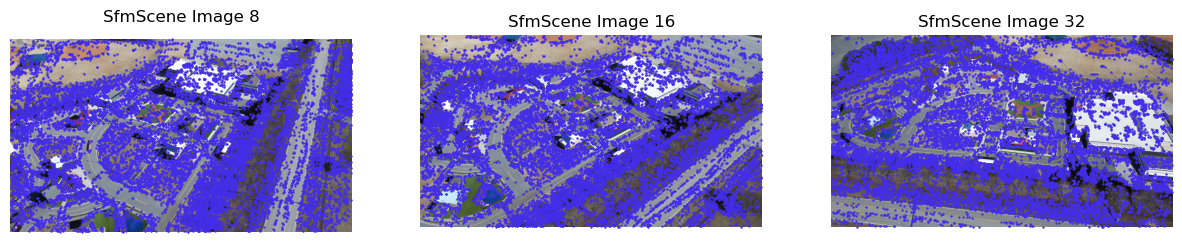

In [3]:
dataset_path = "./data/safety_park"
sfm_scene = frc.SfmScene.from_colmap(dataset_path)

# Visualize an image in an SfmScene and the 3D points visible from that images
# projected onto the image plane as blue dots.
def plot_image_from_scene(scene: frc.SfmScene, image_id: int):
    image_meta: frc.SfmImageMetadata = scene.images[image_id]
    camera_meta: frc.SfmCameraMetadata = image_meta.camera_metadata

    # Get the visible 3d points for this image
    visible_points_3d: np.ndarray = scene.points[image_meta.point_indices]

    # Project those points onto the image plane
    # 1. Get the world -> camera space transform and projection matrix
    world_to_cam_matrix: np.ndarray = image_meta.world_to_camera_matrix
    projection_matrix: np.ndarray = camera_meta.projection_matrix
    # 2. Transform world points to camera space
    visible_points_3d_cam_space = world_to_cam_matrix[:3,:3] @ visible_points_3d.T + world_to_cam_matrix[:3,3:4]
    # 3. Transform camera space coordinates to image space
    visible_points_2d = projection_matrix @ visible_points_3d_cam_space
    visible_points_2d /= visible_points_2d[2]

    # Load the image and convert to RGB (OpenCV uses BGR by default)
    loaded_image = cv2.imread(image_meta.image_path)
    assert loaded_image is not None, f"Failed to load image at {image_meta.image_path}"
    loaded_image = cv2.cvtColor(loaded_image, cv2.COLOR_BGR2RGB)

    # Plot the image and projected points
    plt.title(f"SfmScene Image {image_id}")
    plt.axis("off")
    plt.imshow(loaded_image)
    plt.scatter(visible_points_2d[0], visible_points_2d[1], color="#432de9", marker=".", s=2)

# Plot three images and points alongside each other
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plot_image_from_scene(sfm_scene, 8)
plt.subplot(1, 3, 2)
plot_image_from_scene(sfm_scene, 16)
plt.subplot(1, 3, 3)
plot_image_from_scene(sfm_scene, 32)
plt.show()

Here we see three images from our input scene with the sparse points overlaid on the images. Before, we reconstruct this scene using Gaussian Splatting, let's preprocess it a bit to clean it up and make the reconstruction process faster.

In this step, we'll do four preprocessing steps:
 1. Downsample the images by a factor of 4 to speed up Gaussian Splat optimization (loading big images can be time consuming), 
 2. Normalize the scene to a canonical coordinte space (using PCA)
 3. Remove outlier points below the bottom 3rd and top 97th percentiles along the X, Y, and Z, axis.
 4. Remove any images with fewer than 50 points (these images are likely to have bad pose estimates)

In [4]:
cleanup_and_resize_transform = frct.Compose(
    frct.DownsampleImages(image_downsample_factor=4, image_type="jpg", rescaled_jpeg_quality=95),
    frct.NormalizeScene(normalization_type="pca"),
    frct.PercentileFilterPoints(percentile_min=3.0, percentile_max=97.0)
)
cleaned_sfm_scene = cleanup_and_resize_transform(sfm_scene)

print(f"Original scene had {len(sfm_scene.points)} points and {len(sfm_scene.images)} images")
print(f"Cleaned scene has {len(cleaned_sfm_scene.points)} points and {len(cleaned_sfm_scene.images)} images")

INFO:fvdb_reality_capture.transforms.downsample_images.DownsampleImages:Rescaling images using downsample factor 4, sampling mode 3, and quality 95.
INFO:fvdb_reality_capture.transforms.downsample_images.DownsampleImages:Attempting to load downsampled images from cache.
INFO:fvdb_reality_capture.transforms.normalize_scene.NormalizeScene:Normalizing SfmScene with normalization type: pca
INFO:fvdb_reality_capture.transforms.percentile_filter_points.PercentileFilterPoints:Filtering points based on percentiles: min=[3. 3. 3.], max=[97. 97. 97.]


Original scene had 199702 points and 124 images
Cleaned scene has 168661 points and 124 images


`fvdb_reality_capture` makes processing `SfmScene`s easy via the use of the `fvdb_reality_capture.transforms` module, which exposes a set of composable transforms which can be applied to a scene. The transforms automatically cache their results. This means expensive operations (such as downsampling all the images in a dataset) are transparently cached and only happen once. Note how it took some time to clean up the scene. If we run the process again, it's almost instantaneous due to caching.

In [5]:
%time cleaned_sfm_scene = cleanup_and_resize_transform(sfm_scene)

INFO:fvdb_reality_capture.transforms.downsample_images.DownsampleImages:Rescaling images using downsample factor 4, sampling mode 3, and quality 95.
INFO:fvdb_reality_capture.transforms.downsample_images.DownsampleImages:Attempting to load downsampled images from cache.
INFO:fvdb_reality_capture.transforms.normalize_scene.NormalizeScene:Normalizing SfmScene with normalization type: pca
INFO:fvdb_reality_capture.transforms.percentile_filter_points.PercentileFilterPoints:Filtering points based on percentiles: min=[3. 3. 3.], max=[97. 97. 97.]


CPU times: user 467 ms, sys: 15.1 ms, total: 482 ms
Wall time: 181 ms


## Reconstructing an `SfmScene` using 3d Gaussian Splatting

Now that we have our cleaned up scene, let's reconstruct a radiance field using the 3d Gaussian Splatting originally proposed in the paper ["3D Gaussian Splatting
for Real-Time Radiance Field Rendering"](https://repo-sam.inria.fr/fungraph/3d-gaussian-splatting/) bu Kerbl, Kopanas et.al. `fvdb_reality_capture` uses the optimized implementation of Gaussian splat rendering in the [fvdb-core](https://github.com/openvdb/fvdb-core) library for robustness and performance.

The core tool for Gaussian Splat reconstruction is the `fvdb_reality_capture.GaussianSplatReconstruction` class. It accepts an input `SfmScene` and optional config parameters, and produces an `fvdb.GaussianSplat3d` reconstructing the scene.

In [ ]:
# We'll just reconstruct our scene using the default settings, which are good in most cases.
# See the documentation for `frc.GaussianSplatReconstruction` for details on the available options.
# Note that this process can take a while depending on the size of your scene.
runner = frc.GaussianSplatReconstruction.from_sfm_scene(cleaned_sfm_scene)
model, metadata = runner.train()

INFO:fvdb_reality_capture.training.scene_optimization_runner.GaussianSplatReconstruction:Created dataset training and test datasets with 124 training images and 0 test images.
INFO:fvdb_reality_capture.training.scene_optimization_runner.GaussianSplatReconstruction:Model initialized with 168,661 Gaussians
INFO:fvdb_reality_capture.training.scene_optimization_runner.GaussianSplatReconstruction:No results will be saved. You can set `results_path` to save the training run.
INFO:fvdb_reality_capture.training.scene_optimization_runner.GaussianSplatReconstruction:Generated a unique run name '67220287-e33d-494c-91f2-9e2325c41a15' for this run.
Training:   0%|          | 0/24800 [00:00<?, ?imgs/s]INFO:fvdb_reality_capture.training.scene_optimization_runner.GaussianSplatReconstruction:Starting to optimize camera poses at step 0 (epoch 0)
loss=0.027| sh degree=3| num gaussians=1,272,671:  90%|████████▉ | 22268/24800 [05:48<00:49, 50.84imgs/s]